In [3]:
from zurich_move_data_extraction import *
from activity_count_function import *
from utilities import *
from gm_function import *
from individual_analysis_ac_functions import *
from extract_mask_from_video import *
from individual_analysis_fs_functions import *
from gm_function import *
from group_analysis_functions import *

In [4]:
#CHANGE VALUES HERE#
# H for Healthy and S for Stroke 
participant_id = 'S003'
participant_group = 'S'

In [5]:
#PATH 
initial_path = '../CreateStudy'
# Join the initial_path and participant_id
participant_path = os.path.join(initial_path, participant_id)
print(participant_path)

../CreateStudy\S003


In [6]:
# Extract dataset from the participant JSON file 
participant_data = load_participant_json(participant_id, initial_path)
# Get the correct handiness 
# For stroke, dominant hand = non affected hand 
dominant_hand = get_dominant_hand(participant_data)

In [7]:
# Get the data from csv files 
ndh_data, chest_data, dh_data, GT_mask_ndh, GT_mask_dh = get_data(participant_path, dominant_hand)
# Ensure the array sizes consistency between masks and IMU data
print (len(GT_mask_ndh)*2, len(ndh_data))

70080 70080


In [8]:
# Get useful variables
sampling_freq = 50
acc_ndh = ndh_data[['acc_x', 'acc_y', 'acc_z']]
acc_dh = dh_data[['acc_x', 'acc_y', 'acc_z']]
gyro_ndh = ndh_data[['gyro_x', 'gyro_y', 'gyro_z']]
gyro_dh = dh_data[['gyro_x', 'gyro_y', 'gyro_z']]
mag_ndh = ndh_data[['magneto_x', 'magneto_y', 'magneto_z']]
quat_sensor_ndh = ndh_data[['quat_0', 'quat_1', 'quat_2','quat_3']]
quat_sensor_dh = dh_data[['quat_0', 'quat_1', 'quat_2','quat_3']]
frequency_AC = 1 # Hz 
frequency_GM = 2 # Hz
FPS_mask = 25 # Hz

In [9]:
# Load usefull values from the participant dataset #

# Load Brond AC values from the participant dataset  
AC_ndh, AC_dh = get_attribute(participant_data, 'AC_NDH', 'AC_DH')

# Load GT mask @ 50 Hz used for GM computation 
GT_mask_NDH_50Hz, GT_mask_DH_50Hz = get_attribute(participant_data, 'GT_mask_NDH_50Hz', 'GT_mask_DH_50Hz')
# Load GT mask @ 2 Hz used for GM evaluation 
GT_mask_NDH_2Hz, GT_mask_DH_2Hz = get_attribute(participant_data, 'GT_mask_NDH_2Hz', 'GT_mask_DH_2Hz')
# Load GT mask @ 1 Hz used for GMAC evaluation 
GT_mask_NDH_1Hz, GT_mask_DH_1Hz = get_attribute(participant_data, 'GT_mask_NDH_1Hz', 'GT_mask_DH_1Hz')

# Load optimal AC thresholds used for GMAC computation 
optimal_AC_NDH, optimal_AC_DH = get_attribute(participant_data, 'optimal_AC_NDH', 'optimal_AC_DH')

In [10]:
# Create Bilateral mask 
GT_mask_BIL_1Hz = get_mask_bilateral(GT_mask_NDH_1Hz, GT_mask_DH_1Hz)

In [11]:
## GM Algorithm Computation ##

In [12]:
# Get Euler angles usign Madgwick sensor fusiona algorithm 
# Left wrist
roll_mad_ndh, pitch_mad_ndh, yaw_mad_ndh = compute_euler_angles(acc_ndh, gyro_ndh, sampling_freq)
# Right wrist 
roll_mad_dh, pitch_mad_dh, yaw_mad_dh = compute_euler_angles(acc_dh, gyro_dh, sampling_freq)

Using IMU Madgwick with acc and gyro only
Using IMU Madgwick with acc and gyro only


In [13]:
# Ensure the datasets have the same sizes 
# For ndh
pitch_mad_ndh, GT_mask_50Hz_ndh = remove_extra_elements(pitch_mad_ndh, GT_mask_NDH_50Hz)
yaw_mad_ndh, GT_mask_50Hz_ndh = remove_extra_elements(yaw_mad_ndh, GT_mask_NDH_50Hz)
# For dh
pitch_mad_dh, GT_mask_50Hz_dh = remove_extra_elements(pitch_mad_dh, GT_mask_DH_50Hz)
yaw_mad_dh, GT_mask_50Hz_dh = remove_extra_elements(yaw_mad_dh, GT_mask_DH_50Hz)

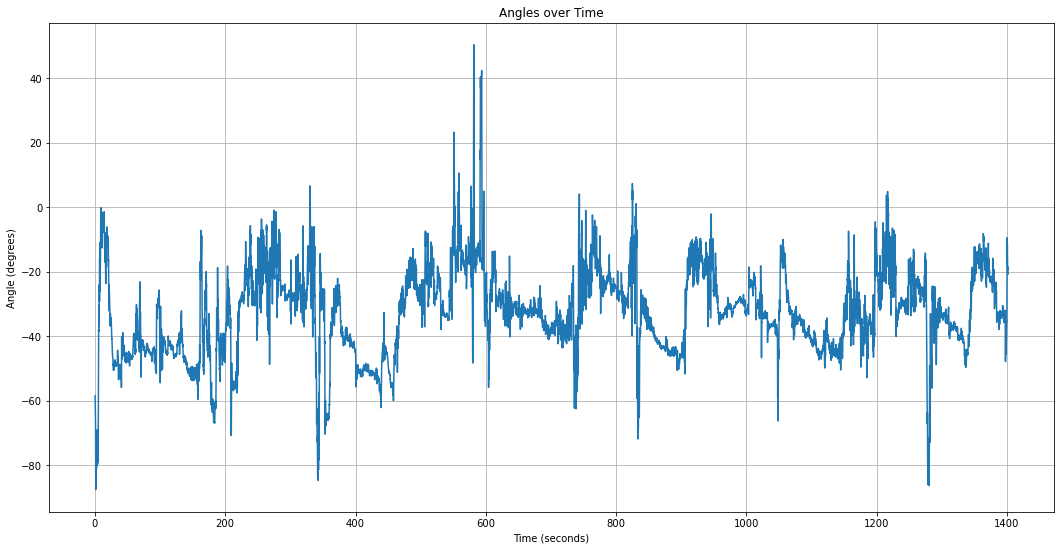

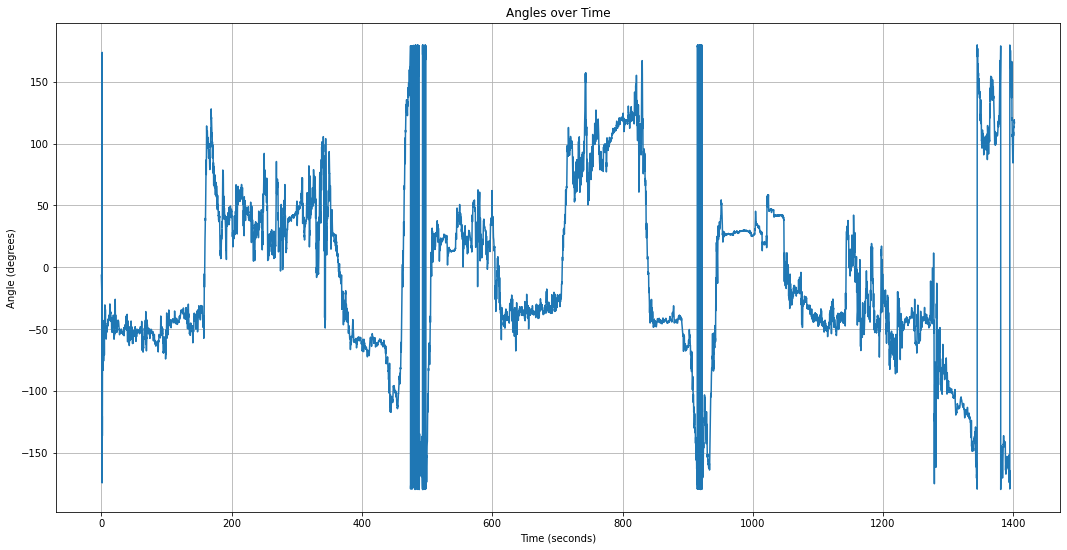

In [14]:
plot_angles_over_time(pitch_mad_ndh)
plot_angles_over_time(yaw_mad_ndh)

In [15]:
# Add Euler angles to participant dataset 
add_attributes_to_participant(participant_data, pitch_NDH = pitch_mad_ndh, yaw_NDH = yaw_mad_ndh,
                              pitch_DH = pitch_mad_dh, yaw_DH = yaw_mad_dh)

In [16]:
# Computation of an optimal FS for the GM algorithm # 

In [17]:
# Optimal Left wrist 
eval_metrics_fs_opt_ndh, optimal_fs_ndh = optimal_fs_computation(pitch_mad_ndh, yaw_mad_ndh, GT_mask_NDH_50Hz,
                                                               k=5, random_state=42, optimal=True)

# Conventional Left wrist 
eval_metrics_fs_conv_ndh, _ = optimal_fs_computation(pitch_mad_ndh, yaw_mad_ndh, GT_mask_NDH_50Hz,
                                                    k=5, random_state=42, optimal=False)

In [18]:
# Optimal Right wrist 
eval_metrics_fs_opt_dh, optimal_fs_dh = optimal_fs_computation(pitch_mad_dh, yaw_mad_dh, GT_mask_DH_50Hz,
                                                               k=5, random_state=42, optimal=True)

# Conventional Right wrist 
eval_metrics_fs_conv_dh, _ = optimal_fs_computation(pitch_mad_dh, yaw_mad_dh, GT_mask_DH_50Hz,
                                                    k=5, random_state=42, optimal=False)

In [19]:
# Optimal Bilateral 
eval_metrics_fs_opt_bil = optimal_fs_computation_bilateral(pitch_mad_ndh, yaw_mad_ndh, GT_mask_NDH_50Hz,
                                     pitch_mad_dh, yaw_mad_dh, GT_mask_DH_50Hz,
                                     optimal_fs_ndh, optimal_fs_dh,k=5, random_state=42, optimal=True)

# Conventional Bilateral 
eval_metrics_fs_conv_bil = optimal_fs_computation_bilateral(pitch_mad_ndh, yaw_mad_ndh, GT_mask_NDH_50Hz,
                                     pitch_mad_dh, yaw_mad_dh, GT_mask_DH_50Hz,
                                     optimal_fs_ndh, optimal_fs_dh,k=5, random_state=42, optimal=False)

In [20]:
# Optimal FS for this participant 
print(optimal_fs_ndh, optimal_fs_dh)

81.0 45.0


In [21]:
eval_metrics_fs_conv_bil

{'Sensitivity': 54.60574341830253,
 'Specificity': 78.77378628182399,
 'Accuracy': 74.85714285714286,
 'PPV': 33.25797998910582,
 'NPV': 89.9704727074101}

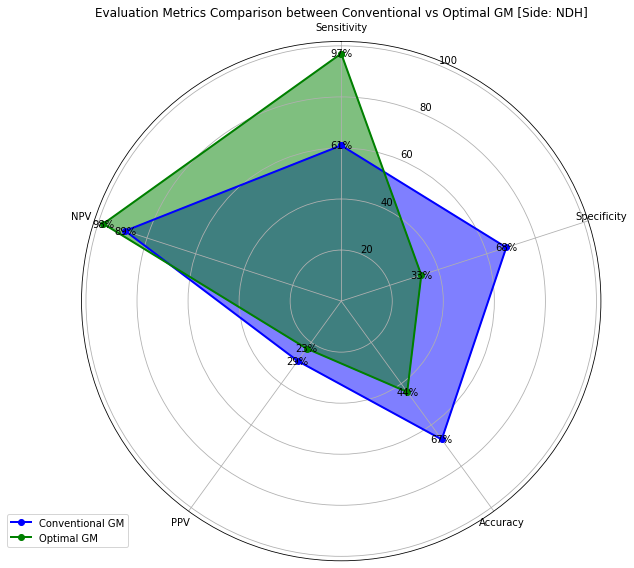

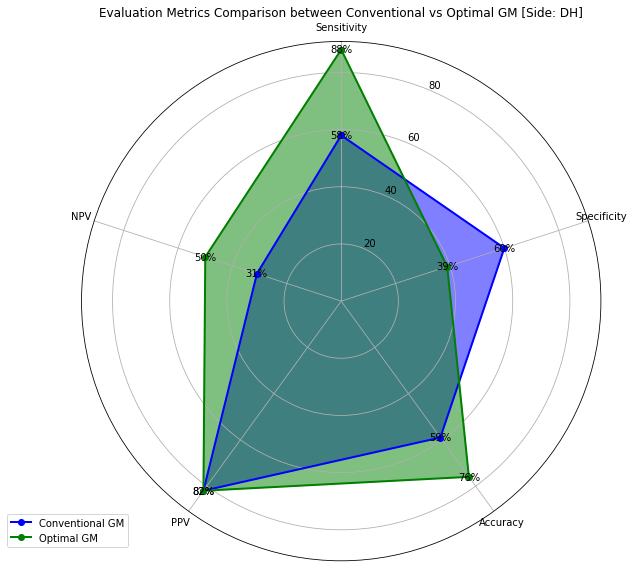

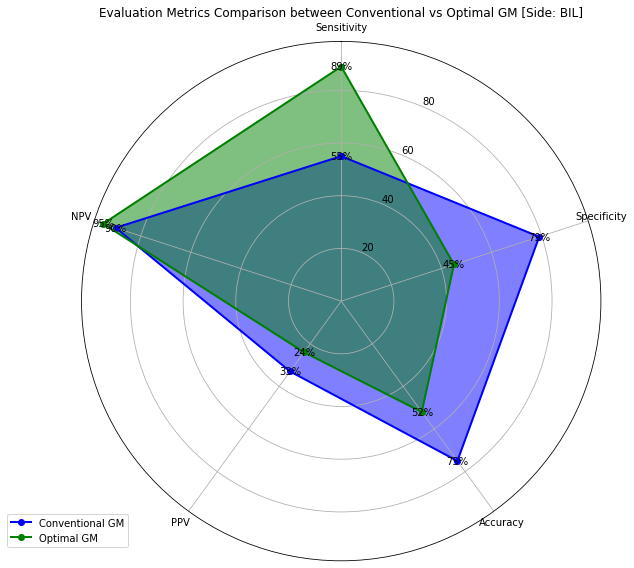

In [22]:
plot_radar_chart(eval_metrics_fs_conv_ndh, eval_metrics_fs_opt_ndh, metric = 'GM', scenario = 'ndh')
plot_radar_chart(eval_metrics_fs_conv_dh, eval_metrics_fs_opt_dh, metric = 'GM', scenario = 'dh')
plot_radar_chart(eval_metrics_fs_conv_bil, eval_metrics_fs_opt_bil, metric = 'GM', scenario = 'bil')

In [23]:
# Saving data for this participant # 

In [24]:
# Create a structure to save all the metrics 
metrics_dictionary_GM = create_metrics_dictionary(eval_metrics_fs_conv_ndh, eval_metrics_fs_conv_dh, eval_metrics_fs_conv_bil, eval_metrics_fs_opt_ndh, eval_metrics_fs_conv_dh, eval_metrics_fs_opt_bil)

In [25]:
# Add new data to the participant dataset 
# Add metrics for FS parameter evaluation
add_attributes_to_participant(participant_data, metrics_dictionary_GM = metrics_dictionary_GM) 
# Add optimal FS parameter
add_attributes_to_participant(participant_data, optimal_FS_NDH = optimal_fs_ndh, optimal_FS_DH = optimal_fs_dh) 

In [26]:
# GMAC # 

In [27]:
# For the NDH 
gmac_ndh_conv = compute_GMAC(pitch_mad_ndh, AC_ndh, ac_threshold = 0, functional_space = 30)
eval_metrics_gmac_conv_ndh = get_evaluation_metrics(GT_mask_NDH_1Hz, gmac_ndh_conv)

gmac_ndh_opt = compute_GMAC(pitch_mad_ndh, AC_ndh, ac_threshold = optimal_AC_NDH, functional_space = optimal_fs_ndh)
eval_metrics_gmac_opt_ndh = get_evaluation_metrics(GT_mask_NDH_1Hz, gmac_ndh_opt)

In [28]:
# For the DH 
gmac_dh_conv = compute_GMAC(pitch_mad_dh, AC_dh, ac_threshold = 0, functional_space = 30)
eval_metrics_gmac_conv_dh = get_evaluation_metrics(GT_mask_DH_1Hz, gmac_dh_conv)

gmac_dh_opt = compute_GMAC(pitch_mad_dh, AC_dh, ac_threshold = optimal_AC_DH, functional_space = optimal_fs_dh)
eval_metrics_gmac_opt_dh = get_evaluation_metrics(GT_mask_DH_1Hz, gmac_dh_opt)

In [29]:
# For the bilateral usage 
# Conventional 
gmac_bil_conv = get_mask_bilateral(gmac_ndh_conv, gmac_dh_conv)
eval_metrics_gmac_conv_bil = get_evaluation_metrics(GT_mask_BIL_1Hz, gmac_bil_conv)
# Optimal
gmac_bil_opt = get_mask_bilateral(gmac_ndh_opt, gmac_dh_opt)
eval_metrics_gmac_opt_bil = get_evaluation_metrics(GT_mask_BIL_1Hz, gmac_bil_opt)

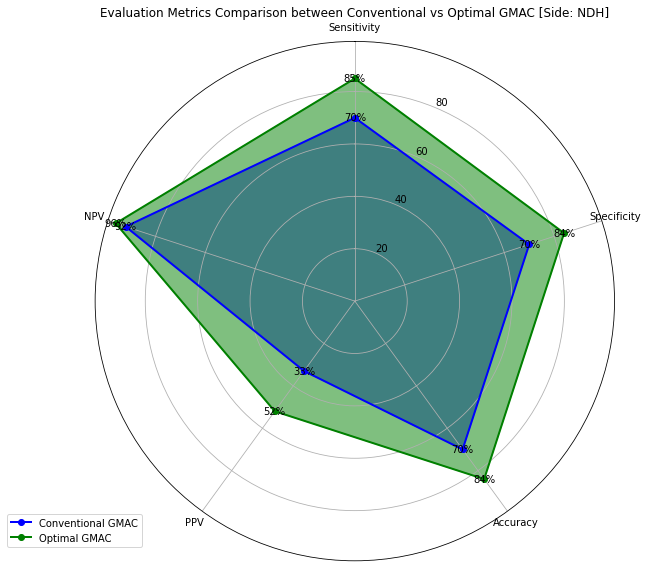

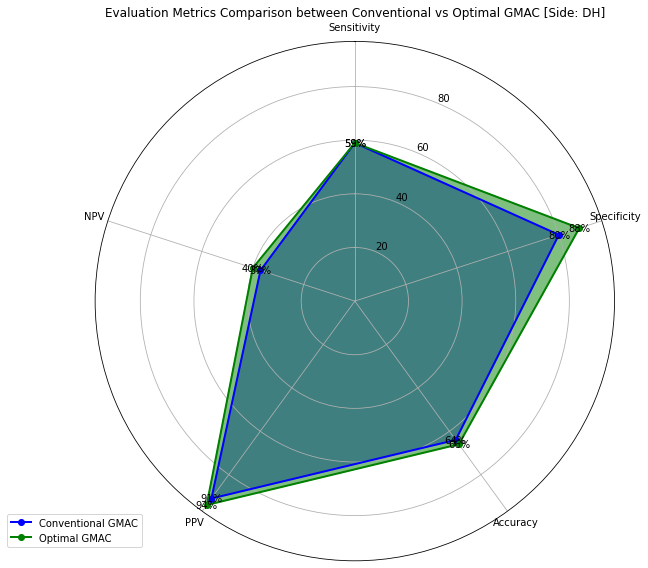

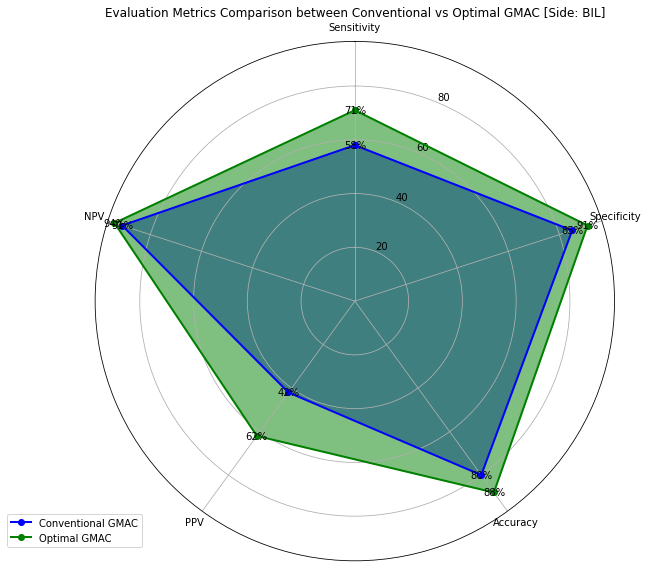

In [30]:
plot_radar_chart(eval_metrics_gmac_conv_ndh, eval_metrics_gmac_opt_ndh, metric = 'GMAC', scenario = 'ndh')
plot_radar_chart(eval_metrics_gmac_conv_dh, eval_metrics_gmac_opt_dh, metric = 'GMAC', scenario = 'dh')
plot_radar_chart(eval_metrics_gmac_conv_bil, eval_metrics_gmac_opt_bil, metric = 'GMAC', scenario = 'bil')

In [31]:
# Create a structure to save all the metrics 
metrics_dictionary_GMAC = create_metrics_dictionary(eval_metrics_gmac_conv_ndh, eval_metrics_gmac_conv_dh, eval_metrics_gmac_conv_bil, eval_metrics_gmac_opt_ndh, eval_metrics_gmac_opt_dh, eval_metrics_gmac_opt_bil)

In [32]:
# Add metrics for GMAC evaluation to the participant dataset
add_attributes_to_participant(participant_data, metrics_dictionary_GMAC = metrics_dictionary_GMAC) 

In [33]:
# Save as a JSON file with the new data  
save_to_json(participant_data, participant_path)

Data saved to: ../CreateStudy\S003\S003.json
